### import packages

In [1]:
import os
import sys
import abc
import random
import math
import copy
from collections import deque, namedtuple
from typing import List, Tuple
import attr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import fsolve, minimize


# Determine the project root directory (adjust the path as necessary)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../../../..'))
print(project_root)
sys.path.append(project_root)


c:\Users\Thomas Gausmann\sciebo - Gausmann, Thomas (t_gaus04@uni-muenster.de)@uni-muenster.sciebo.de\Masterarbeit\price_simulator


In [2]:
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]'

#### Citations for Used Packages

This notebook uses the following packages:

1. **NumPy**  
   Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020). Array programming with NumPy. *Nature*, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2

2. **Matplotlib**  
   Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. *Computing in Science & Engineering*, 9(3), 90–95. https://doi.org/10.1109/MCSE.2007.55

3. **PyTorch**  
   Paszke, A., Gross, S., Massa, F., et al. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. *Advances in Neural Information Processing Systems*, 32, 8024–8035. https://papers.nips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library

4. **TensorDict and TorchRL**  
   TorchRL Documentation. https://pytorch.org/rl/

5. **Keras**  
   Chollet, F., & others. (2015). Keras. https://keras.io

6. **SciPy**  
   Virtanen, P., Gommers, R., Oliphant, T. E., et al. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. *Nature Methods*, 17, 261–272. https://doi.org/10.1038/s41592-019-0686-2

7. **Seaborn**  
   Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. https://doi.org/10.21105/joss.03021

8. **Attr**  
   Hynek Schlawack. attrs: Classes Without Boilerplate. https://www.attrs.org

9. **Random**  
   Python Standard Library. https://docs.python.org/3/library/random.html

10. **ABC (Abstract Base Classes)**  
    Python Standard Library. https://docs.python.org/3/library/abc.html

11. **Deque**  
    Python Standard Library. https://docs.python.org/3/library/collections.html#collections.deque


## Algorithm Related

### Simple Strategies

In [3]:
@attr.s
class AgentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Price setting agents"""

    marginal_cost: float = attr.ib(default=1.0)
    quality: float = attr.ib(default=2.0)

    @marginal_cost.validator
    def check_marginal_costs(self, attribute, value):
        if not value >= 0.0:
            raise ValueError("Marginal costs must be positive")

    @quality.validator
    def check_quality_costs(self, attribute, value):
        if not self.marginal_cost <= value:
            raise ValueError("Quality must be at least as high as marginal costs to be active in market")

    @abc.abstractmethod
    def play_price(self, state, action_space, n_period, t):
        raise NotImplementedError

    @abc.abstractmethod
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        raise NotImplementedError

    def who_am_i(self) -> str:
        return type(self).__name__


#### Always Defect Agent

In [4]:
@attr.s
class AlwaysDefectAgent(AgentStrategy):
    """Agent that always defects"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        """Always play the lowest possible price."""
        return min(action_space)

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        pass


#### Always Max Price

In [5]:
@attr.s
class AlwaysMaxAgent(AlwaysDefectAgent):
    """Agent that always plays maximum price"""

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        """Always play the highest possible price."""
        return max(action_space)

#### TitForTat Agent

In [6]:
@attr.s
class TitForTat(AlwaysDefectAgent):
    """
    Tit for Tat Agent.

    If opponent undercut last period play lowest price.
    Otherwise play opponent last periods price.
    Agent must be second in list. Only two agents possible.

    """

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        if state[0] < state[1]:
            return min(action_space)
        else:
            return state[0]

#### Follower Agent

In [7]:
@attr.s
class Follower(AlwaysDefectAgent):
    """
    Always plays the minimum price of last period.
    Agent must be last in list.
    
    """

    def play_price(self, state: Tuple, action_space: List, n_period: int, t: int):
        competitor_actions = state[:-1]
        min_competitor = int(np.where(np.array(action_space) == min(competitor_actions))[0])
        
        return action_space[min_competitor]

### Policies (Exploration)

In [8]:
@attr.s
class ExplorationStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Exploration decision."""

    def who_am_i(self) -> str:
        return type(self).__name__

    def epsilon(self, length: int, time: int) -> float:
        raise NotImplementedError

    def explore(self, n_period: int, t: int) -> bool:
        epsilon = self.epsilon(n_period, t)
        return random.choices([True, False], weights=[epsilon, 1 - epsilon])[0]


#### Constant Epsilon

In [9]:
@attr.s
class EpsilonGreedy(ExplorationStrategy):
    """Exploration decision based on fixed epsilon greedy policy."""

    eps: float = attr.ib(default=0.1)

    @eps.validator
    def check_epsilon(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Epsilon must lie in [0,1]")

    def who_am_i(self) -> str:
        return type(self).__name__ + " ({})".format(self.eps)

    def epsilon(self, length: int, time: int) -> float:
        return self.eps

#### Decreasing Epsilon

In [10]:
@attr.s
class DecreasingEpsilonGreedy(ExplorationStrategy):
    """
    Exploration decision with decreasing epsilon.
    Adapts dynamically to different simulation lengths

    """

    beta: float = attr.ib(default=0.015)

    def epsilon(self, length: int, time: int) -> float:
        """Returns epsilon for time step, such that after half of the time epsilon is 0.001"""
        return (self.beta ** (1.0 / (length / 2))) ** time


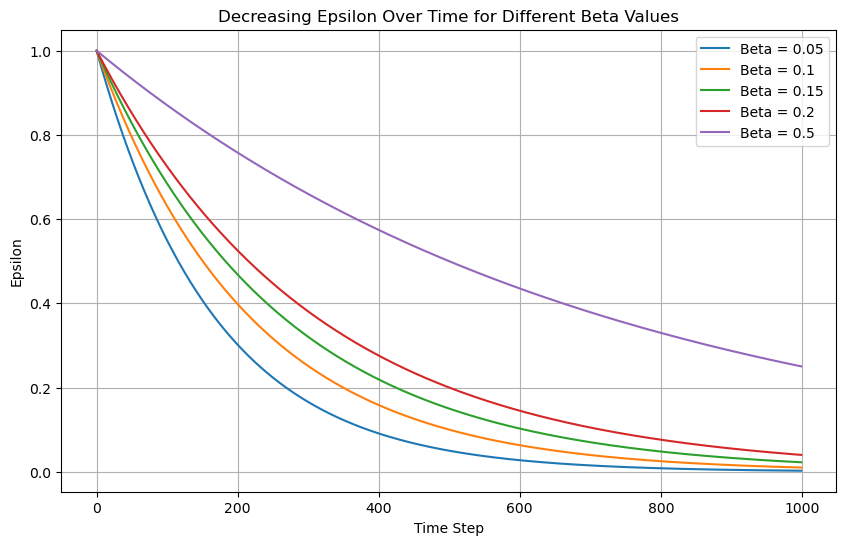

In [11]:
# Define different beta values
beta_values = [0.05, 0.1, 0.15, 0.2, 0.5]

# Define the number of periods and time steps
n_periods = 1000
time_steps = range(n_periods)

# Plot the decreasing epsilon for each beta value
plt.figure(figsize=(10, 6))
for beta in beta_values:
	# Initialize the DecreasingEpsilonGreedy instance
	decreasing_epsilon = DecreasingEpsilonGreedy(beta=beta)
	
	# Calculate epsilon values for each time step
	epsilon_values = [decreasing_epsilon.epsilon(n_periods, t) for t in time_steps]
	
	# Plot the epsilon values
	plt.plot(time_steps, epsilon_values, label=f"Beta = {beta}")

# Add plot details
plt.title("Decreasing Epsilon Over Time for Different Beta Values")
plt.xlabel("Time Step")
plt.ylabel("Epsilon")
plt.legend()
plt.grid()
plt.show()

## Economic Environment
### Demand


In [12]:
@attr.s
class MarketDemandStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for all market demand modulation."""

    @abc.abstractmethod
    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        """Return demand quanities for each price"""
        raise NotImplementedError()


#### Logit Demand

In [13]:
@attr.s
class LogitDemand(MarketDemandStrategy):
    """Market demand modulation for logit demand"""

    price_sensitivity: float = attr.ib(0.25)  # lower more sensitive
    outside_quality: float = attr.ib(0.0)

    @price_sensitivity.validator
    def check_price_sensitivity(self, attribute, value):
        if not 0.005 <= value:
            raise ValueError("Price Sensitivity must lie above 0.005")

    def get_quantities(self, prices: Tuple, qualities: Tuple) -> Tuple:
        denominator = sum((math.exp((a - p) / self.price_sensitivity) for a, p in zip(qualities, prices))) + math.exp(
            self.outside_quality / self.price_sensitivity
        )
        return tuple(math.exp((a - p) / self.price_sensitivity) / denominator for a, p in zip(qualities, prices))


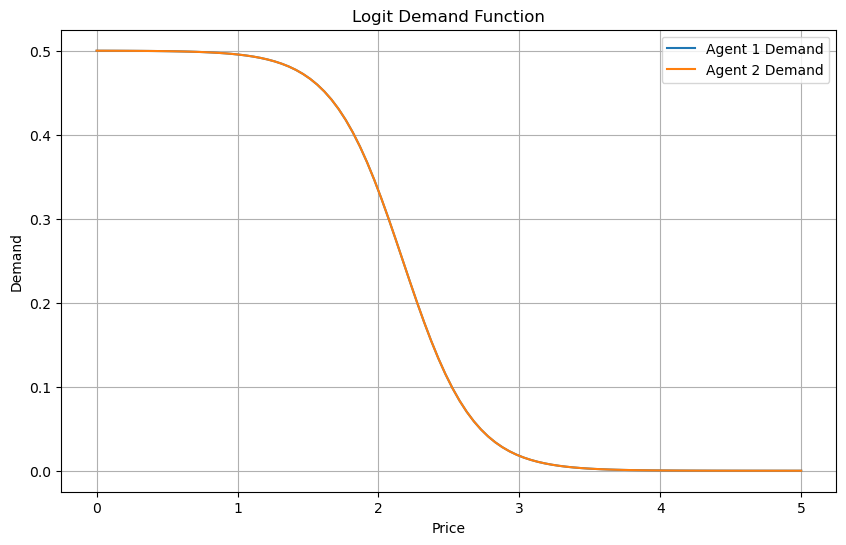

In [14]:
# Define the qualities and price range
qualities = (2, 2)
price_range = np.linspace(0, 5, 100)  # Vary prices from 0 to 5

# Initialize the LogitDemand instance
logit_demand = LogitDemand(price_sensitivity=0.25, outside_quality=0.0)

# Calculate demand for each price combination
demands = []
for price in price_range:
	demands.append(logit_demand.get_quantities((price, price), qualities))

# Extract demands for each agent
agent_1_demand = [d[0] for d in demands]
agent_2_demand = [d[1] for d in demands]

# Plot the demand curves
plt.figure(figsize=(10, 6))
plt.plot(price_range, agent_1_demand, label="Agent 1 Demand")
plt.plot(price_range, agent_2_demand, label="Agent 2 Demand")
plt.title("Logit Demand Function")
plt.xlabel("Price")
plt.ylabel("Demand")
plt.legend()
plt.grid()
plt.show()

In [15]:
LogitDemand().get_quantities((0, sys.float_info.max), (1, 1))

(0.9820137900379085, 0.0)

### Equilibrium

In [16]:
@attr.s
class EquilibriumCalculator(object):
    """Find equilibrium (Monopoly and Nash) for market environment specified by marginal costs, qualities and demand."""

    demand: MarketDemandStrategy = attr.ib()

    def get_nash_equilibrium(self, qualities: List, marginal_costs: List) -> np.array:
        """Calculate prices that makes market outcome an equilibrium"""
        param = (qualities, marginal_costs)
        p0 = np.array(marginal_costs)
        return fsolve(self.vector_reaction, p0, args=param)

    def profit(
        self, own_price: float, prices: np.array, qualities: np.array, marginal_costs: np.array, i: int
    ) -> float:
        """Calculate profit for ith firm if it sets his price to own_price given competitor prices."""
        temp_prices = copy.deepcopy(prices)
        temp_prices[i] = own_price
        return -1 * (temp_prices[i] - marginal_costs[i]) * self.demand.get_quantities(temp_prices, qualities)[i]

    def reaction_function(self, prices: np.array, qualities: np.array, marginal_costs: np.array, i: float) -> float:
        """Get price (optimal reaction) that maximizes own profit for given competitor prices."""
        return minimize(
            fun=self.profit,
            x0=np.array(marginal_costs[i]),
            args=(prices, qualities, marginal_costs, i),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x[0]

    def vector_reaction(self, nash_prices: np.array, qualities: np.array, marginal_costs: np.array) -> np.array:
        """Vector representation of the fix-point for Nash prices."""
        return np.array(nash_prices) - np.array(
            [self.reaction_function(nash_prices, qualities, marginal_costs, i) for i in range(len(nash_prices))]
        )

    def get_monopoly_outcome(self, qualities: List, marginal_costs: List) -> np.array:
        """Get prices that maximize joint profit."""
        return minimize(
            fun=self.joint_profit,
            x0=np.array(qualities),
            args=(qualities, marginal_costs),
            method="nelder-mead",
            options={"xatol": 1e-8},
        ).x

    def joint_profit(self, prices: np.array, qualities: np.array, marginal_costs: np.array) -> float:
        """Return (negative) joint profit for prices."""
        return -1 * np.sum(
            np.multiply(np.subtract(prices, marginal_costs), self.demand.get_quantities(prices, qualities))
        )


### Storage

In [17]:
@attr.s
class Storage:
    counter = attr.ib(default=0)
    update_steps = attr.ib(init=False)
    running_rewards = attr.ib(init=False)
    running_quantities = attr.ib(init=False)
    running_actions = attr.ib(init=False)
    average_rewards = attr.ib(default=None)
    average_quantities = attr.ib(default=None)
    average_actions = attr.ib(default=None)

    def set_up(self, n_agents: int, n_periods: int, desired_length: int = 1000):
        self.reset_running_storage(n_agents)
        self.update_steps = max(1, np.round(n_periods / desired_length, 0))

    def reset_running_storage(self, n_agents: int):
        self.running_rewards = np.array([0] * n_agents)
        self.running_quantities = np.array([0] * n_agents)
        self.running_actions = np.array([0] * n_agents)

    def observe(self, rewards: np.array, actions: np.array, quantities: np.array):
        self.counter += 1
        self.running_rewards = self.incremental_update(rewards, self.running_rewards, self.counter)
        self.running_quantities = self.incremental_update(quantities, self.running_quantities, self.counter)
        self.running_actions = self.incremental_update(actions, self.running_actions, self.counter)

        if self.counter == self.update_steps:
            if self.average_actions is not None:
                self.average_rewards = np.vstack([self.average_rewards, self.running_rewards])
                self.average_actions = np.vstack([self.average_actions, self.running_actions])
                self.average_quantities = np.vstack([self.average_quantities, self.running_quantities])
            else:
                self.average_rewards = copy.deepcopy(self.running_rewards)
                self.average_actions = copy.deepcopy(self.running_actions)
                self.average_quantities = copy.deepcopy(self.running_quantities)

            self.reset_running_storage(len(rewards))
            self.counter = 0

    @staticmethod
    def incremental_update(observation: np.array, average: np.array, cnt: int) -> np.array:
        return average + (observation - average) / cnt

    def print(self):
        print("Rewards:", self.average_rewards)
        print("Prices:", self.average_actions)
        print("Quantities:", self.average_quantities)


### Environment

In [18]:
import seaborn as sns

@attr.s
class EnvironmentStrategy(metaclass=abc.ABCMeta):
    """Top-level interface for Environment."""

    agents: List[AgentStrategy] = attr.ib(factory=list)
    possible_prices: List[float] = attr.ib(factory=list)
    demand: MarketDemandStrategy = attr.ib(factory=LogitDemand)
    nash_prices: np.array = attr.ib(init=False)
    monopoly_prices: np.array = attr.ib(init=False)

    def __attrs_post_init__(self):
        """Compute Nash Price and Monopoly price after initialization."""
        if len(self.agents) > 0.0:
            marginal_costs = [agent.marginal_cost for agent in self.agents]
            qualities = [agent.quality for agent in self.agents]
            self.monopoly_prices = EquilibriumCalculator(demand=self.demand).get_monopoly_outcome(
                qualities, marginal_costs
            )
            self.nash_prices = EquilibriumCalculator(demand=self.demand).get_nash_equilibrium(
                qualities, marginal_costs
            )

    @abc.abstractmethod
    def play_game(self):
        raise NotImplementedError


@attr.s
class DiscreteSynchronEnvironment(EnvironmentStrategy):
    """Environment for discrete states and prices.

     Before the first iteration, prices are randomly initialized.
     Agents set prices at the same time.
     After choosing prices, demand and rewards are calculated.
     Then agents have the opportunity to learn.
     """

    n_periods: int = attr.ib(default=1)
    markup: float = attr.ib(default=0.1)
    n_prices: int = attr.ib(default=15)
    convergence_after: int = attr.ib(default=np.inf)
    history_after: int = attr.ib(default=np.inf)
    price_history: List = attr.ib(factory=list)
    quantity_history: List = attr.ib(factory=list)
    reward_history: List = attr.ib(factory=list)
    storage: Storage = attr.ib(factory=Storage)

    @n_periods.validator
    def check_n_periods(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of periods must be strictly positive")

    @markup.validator
    def check_markup(self, attribute, value):
        if not 0 <= value:
            raise ValueError("Price markup must be positive")

    @n_prices.validator
    def check_n_prices(self, attribute, value):
        if not 0 < value:
            raise ValueError("Number of prices must be strictly positive")

    def play_game(self) -> int:

        qualities = tuple(agent.quality for agent in self.agents)
        marginal_costs = tuple(agent.marginal_cost for agent in self.agents)

        # initialize first rounds
        if len(self.possible_prices) == 0:
            self.possible_prices = self.get_price_range(
                min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
            )
        previous_state = tuple(random.choices(self.possible_prices, k=len(self.agents)))
        state = tuple(
            agent.play_price(previous_state, self.possible_prices, self.n_periods, 0) for agent in self.agents
        )
        quantities = self.demand.get_quantities(state, qualities)
        previous_rewards = np.multiply(np.subtract(state, marginal_costs), quantities)

        # set up storage
        self.storage.set_up(len(self.agents), self.n_periods)

        for t in range(self.n_periods):
            # Progress indicator
            if t % (self.n_periods // 4) == 0:
                print(f"Period {t}/{self.n_periods}")
                
            # agents decide about there prices (hereafter is the state different)
            next_state = tuple(
                agent.play_price(state, self.possible_prices, self.n_periods, t) for agent in self.agents
            )

            # demand is estimated for prices
            quantities = self.demand.get_quantities(next_state, qualities)
            rewards = np.multiply(np.subtract(next_state, marginal_costs), quantities)

            # assert that everything is correct
            assert (np.array(quantities) >= 0.0).all(), "Quantities cannot be negative"
            assert (np.array(next_state) >= 0.0).all(), "Prices cannot be negative"

            # agents learn
            for agent, action, previous_action, reward, previous_reward in zip(
                self.agents, next_state, state, rewards, previous_rewards
            ):
                agent.learn(
                    previous_reward=previous_reward,
                    reward=reward,
                    previous_action=previous_action,
                    action=action,
                    action_space=self.possible_prices,
                    previous_state=previous_state,
                    state=state,
                    next_state=next_state,
                )

            # update variables
            previous_state = copy.deepcopy(state)
            state = copy.deepcopy(next_state)
            previous_rewards = copy.deepcopy(rewards)

            # save prices for the last periods
            if t > self.history_after:
                self.price_history.append(previous_state)
                self.quantity_history.append(quantities)
                self.reward_history.append(rewards)

            # Fill storage
            self.storage.observe(rewards, state, quantities)

        return t
    
    def show_price_matrix_heatmap(self):
        """Display a heatmap with the best response prices for each price pair."""
        import matplotlib.pyplot as plt

        self.possible_prices = self.get_price_range(
            min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
        )
        price_matrix = np.zeros((len(self.possible_prices), len(self.possible_prices)))

        for i, price_1 in enumerate(self.possible_prices):
            for j, price_2 in enumerate(self.possible_prices):
                state = (price_1, price_2)
                qualities = tuple(agent.quality for agent in self.agents)
                marginal_costs = tuple(agent.marginal_cost for agent in self.agents)
                quantities = self.demand.get_quantities(state, qualities)
                rewards = np.multiply(np.subtract(state, marginal_costs), quantities)
                price_matrix[i, j] = rewards[0]  # Assuming we are interested in the reward of the first agent

        rounded_prices = [round(price, 4) for price in self.possible_prices]

        plt.figure(figsize=(10, 8))
        sns.heatmap(price_matrix, xticklabels=rounded_prices, yticklabels=rounded_prices, cmap="viridis")
        plt.title("Price Matrix Heatmap (Best Response Prices)")
        plt.xlabel("Price of Agent 2")
        plt.ylabel("Price of Agent 1")
        plt.gca().invert_yaxis()  # Ensure the y-axis starts with the lowest price

        # Mark Nash price
        nash_price_1, nash_price_2 = self.nash_prices
        nash_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_1, 2)))
        nash_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_2, 2)))
        plt.scatter(nash_idx_2 + 0.5, nash_idx_1 + 0.5, color='red', label='Nash Price', s=100)

        # Mark Monopoly/Cooperation price
        coop_price_1, coop_price_2 = self.monopoly_prices
        coop_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_1, 2)))
        coop_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_2, 2)))
        plt.scatter(coop_idx_2 + 0.5, coop_idx_1 + 0.5, color='blue', label='Cooperation/Monopoly Price', s=100)

        plt.legend(loc='upper left')
        plt.show()

    def plot_joint_profit(self):
        """Plot the joint profit function over a range of prices."""
        import matplotlib.pyplot as plt

        self.possible_prices = self.get_price_range(
            min(self.nash_prices), max(self.monopoly_prices), self.markup, self.n_prices
        )
        price_matrix = np.zeros((len(self.possible_prices), len(self.possible_prices)))
        qualities = tuple(agent.quality for agent in self.agents)
        marginal_costs = tuple(agent.marginal_cost for agent in self.agents)
        for i, price_1 in enumerate(self.possible_prices):
            for j, price_2 in enumerate(self.possible_prices):
                state = (price_1, price_2)
                joint_profit = EquilibriumCalculator(demand=self.demand).joint_profit(
                    state, qualities, marginal_costs
                )
                price_matrix[i, j] = joint_profit
        rounded_prices = [round(price, 2) for price in self.possible_prices]

        plt.figure(figsize=(10, 8))
        sns.heatmap(price_matrix, xticklabels=rounded_prices, yticklabels=rounded_prices, cmap="coolwarm")
        plt.title("Joint Profit Function")
        plt.xlabel("Price of Agent 2")
        plt.ylabel("Price of Agent 1")
        plt.gca().invert_yaxis()  # Ensure the y-axis starts with the lowest price

        # Mark Nash price
        nash_price_1, nash_price_2 = self.nash_prices
        nash_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_1, 2)))
        nash_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(nash_price_2, 2)))
        plt.scatter(nash_idx_2 + 0.5, nash_idx_1 + 0.5, color='red', label='Nash Price', s=100)

        # Mark Monopoly/Cooperation price
        coop_price_1, coop_price_2 = self.monopoly_prices
        coop_idx_1 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_1, 2)))
        coop_idx_2 = min(range(len(rounded_prices)), key=lambda i: abs(rounded_prices[i] - round(coop_price_2, 2)))
        plt.scatter(coop_idx_2 + 0.5, coop_idx_1 + 0.5, color='blue', label='Cooperation/Monopoly Price', s=100)

        plt.legend(loc='upper left')
        plt.show()

    @staticmethod
    def get_price_range(nash_price: float, monopoly_price: float, markup: float, n_step: int) -> List:
        increase = (monopoly_price - nash_price) * markup
        return list(np.linspace(nash_price - increase, monopoly_price + increase, n_step))



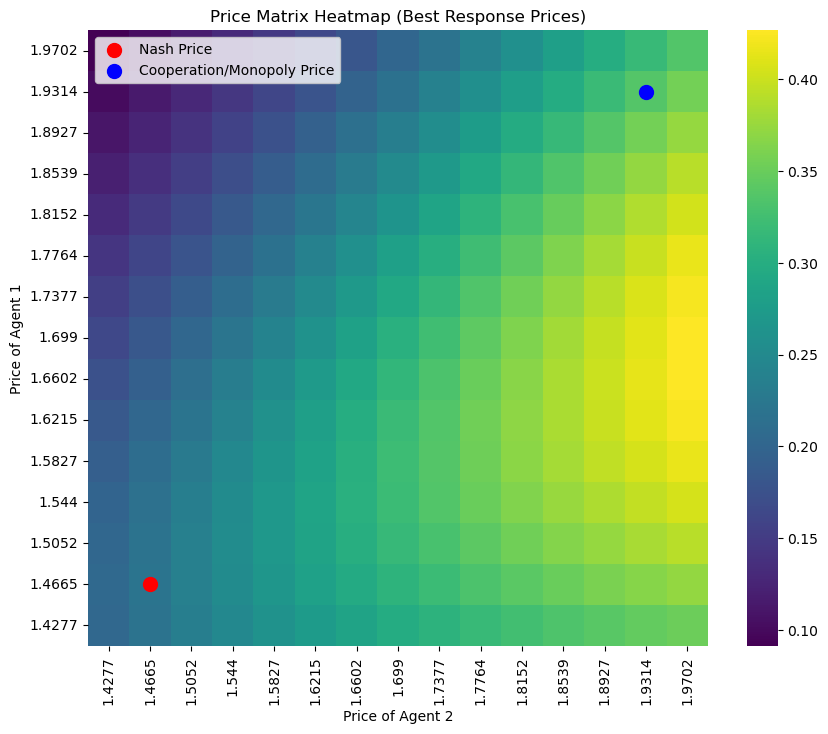

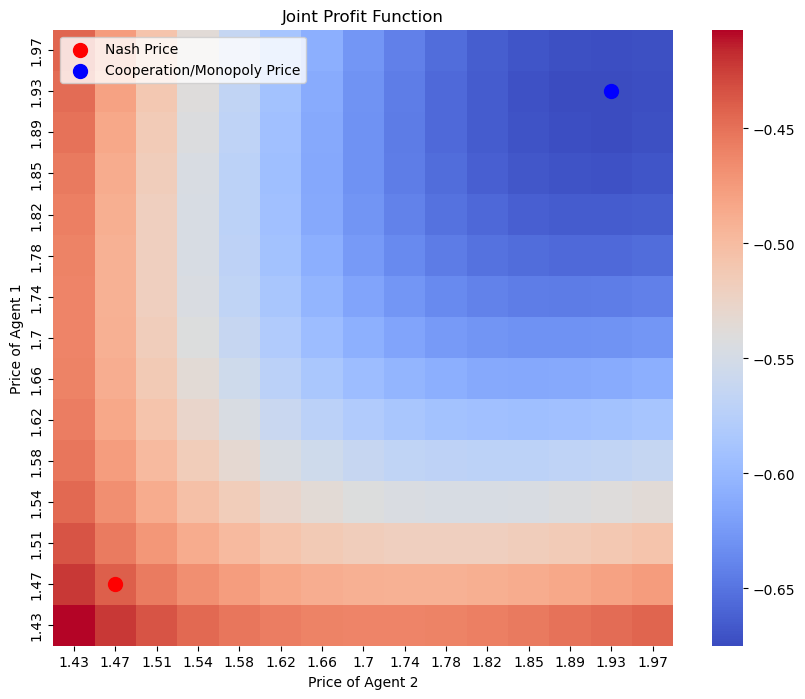

In [19]:
import seaborn as sns

# Create an environment with two AlwaysDefectAgents
env = DiscreteSynchronEnvironment(
	markup=0.1,
	n_periods=1000,
	possible_prices=[],
	n_prices=15,
	demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
	history_after=100,
	agents=[
		AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
		AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
	],
)

# Print the price matrix
env.show_price_matrix_heatmap()
env.plot_joint_profit()

## Serializer

In [20]:
import pickle


def load_object(filename):
    """ Unpickle a file of pickled data. """
    with open(filename, "rb") as f:
        return pickle.load(f)


def load_multiple_objects(filename):
    """ Stream a file of pickled objects. """
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break


def save_object(obj, filename):
    """ Pickle a python object to filename.pkl . """
    with open(filename, "wb") as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def add_object(obj, filename):
    """ Add a python object to filename.pkl . """
    with open(filename, "ab") as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


## Quick Test with 2 Always defect agents

Period 0/1000
Period 250/1000
Period 500/1000
Period 750/1000


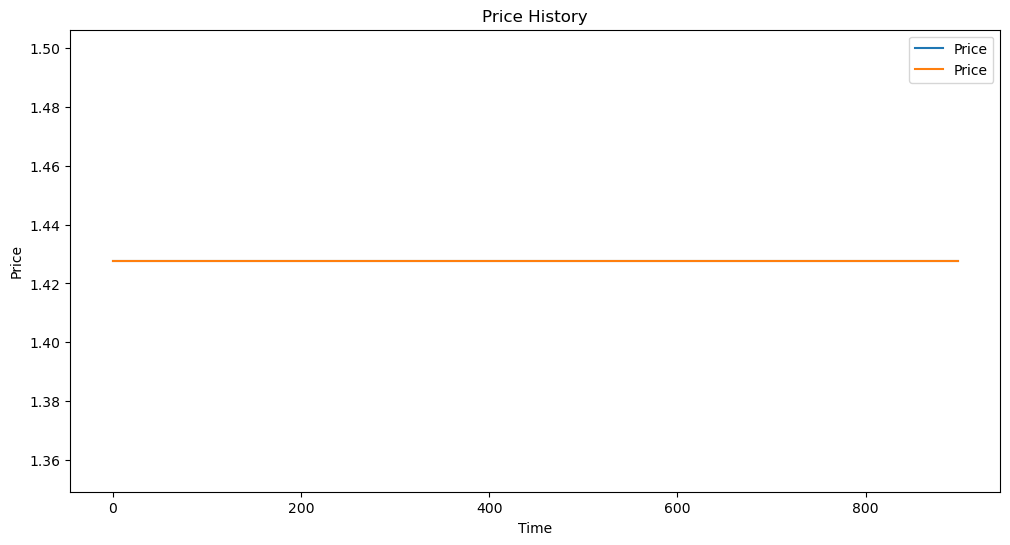

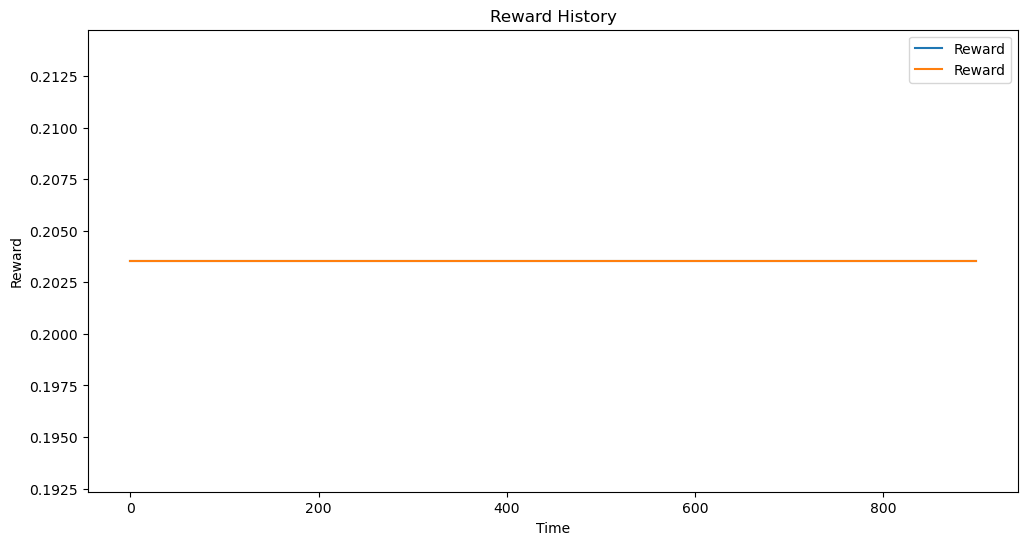

In [21]:
# Test the AlwaysDefectAgent

def create_subplot(data, label):
    for series in data:
        plt.plot(series, label=label)
    plt.legend()

def test_always_defect_agent():
    # Create an environment with AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=1000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=100,
        agents=[
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
            AlwaysDefectAgent(marginal_cost=1.0, quality=2.0),
        ],
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_1 = [price[0] for price in env.price_history]
    price_history_2 = [price[1] for price in env.price_history]

    # Plot price history
    plt.figure(figsize=(12, 6))
    create_subplot([price_history_1, price_history_2], label="Price")
    plt.title("Price History")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

    # Plot reward history
    reward_history_1 = [reward[0] for reward in env.reward_history]
    reward_history_2 = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    create_subplot([reward_history_1, reward_history_2], label="Reward")
    plt.title("Reward History")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.show()

test_always_defect_agent()

## LSTM implementation

In [22]:
import attr
import torch
import random
import numpy as np
from torch import nn, optim
from typing import List, Tuple
from torchrl.data import LazyTensorStorage, TensorDictReplayBuffer, TensorDictPrioritizedReplayBuffer
from tensordict import TensorDict

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

### Simple LSTM Agent

In [23]:

@attr.s
class SimpleLSTMAgent(AgentStrategy):
    """Simplified LSTM Agent using sequences of past states"""

    # LSTM Network
    lstm: LSTMModel = attr.ib(default=None)
    hidden_nodes: int = attr.ib(default=32)
    sequence_length: int = attr.ib(default=5)  # Number of past states to use
    state_history: List[Tuple[float, ...]] = attr.ib(factory=list)

    # General
    decision: ExplorationStrategy = attr.ib(factory=EpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.001)

    # Debugging
    debug: bool = attr.ib(default=False)
    loss_history: List[float] = attr.ib(factory=list, init=False)

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def who_am_i(self) -> str:
        return type(self).__name__ + " (gamma: {}, alpha: {}, policy: {}, quality: {}, mc: {})".format(
            self.discount, self.learning_rate, self.decision.who_am_i(), self.quality, self.marginal_cost
        )

    def update_state_history(self, state: Tuple[float]):
        """Update the history of states with the new state."""
        self.state_history.append(state)
        if len(self.state_history) > self.sequence_length:
            self.state_history.pop(0)
        # Add zero padding if the state history is shorter than the sequence length
        while len(self.state_history) < self.sequence_length:
            self.state_history.insert(0, tuple(0.0 for _ in state))

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""
        # Update state history
        self.update_state_history(self.scale_sequence(state, action_space))

        # Initialize LSTM network if necessary
        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))
            self.optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate, amsgrad=True)

        # Play action
        if self.decision.explore(n_period, t):
            chosen_action = random.choice(action_space)
            return chosen_action
        else:
            # Use state history as input to the LSTM network
            states_input = torch.tensor(self.state_history).float().unsqueeze(0)
            action_values = self.lstm(states_input).detach().numpy()
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])
            chosen_action = action_space[optimal_action_index]
            return chosen_action
        
    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""
        # Update state history with the current state
        self.update_state_history(state)

        # Create a sequence of state history length for the next state
        next_state_history = self.state_history[-self.sequence_length:] + [next_state]
        # Scale the input sequences
        states_input = torch.tensor(self.scale_sequence(self.state_history, action_space)).float().unsqueeze(0)
        next_states_input = torch.tensor(self.scale_sequence(next_state_history, action_space)).float().unsqueeze(0)

        # Compute the target Q-values using the Bellman equation
        next_optimal_q = self.lstm(next_states_input).max().item()
        target = reward + self.discount * next_optimal_q

        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states_input)
        action_idx = np.atleast_1d(action_space == action).nonzero()[0]
        target_tensor = local_estimates.clone().detach()
        target_tensor[0, action_idx] = target

        # Update the LSTM network using backpropagation
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(local_estimates, target_tensor)
        loss.backward()
        optimizer.step()
        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action"""
        return LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)

    def scale_sequence(self, sequences: List[Tuple], action_space: List) -> np.array:
        """Scale float input sequences to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.array([
            np.multiply(np.divide(np.array(seq) - min_action, max_action - min_action), 1) for seq in sequences
        ])
    

In [35]:

@attr.s
class LSTMReplayAgent(SimpleLSTMAgent):
    """LSTM Agent with Replay Buffer and Target Network"""

    # Target Network
    target_lstm: LSTMModel = attr.ib(default=None, init=False)  # Target network
    use_soft_update: bool = attr.ib(default=True)  # Use soft update for target network
    update_counter: int = attr.ib(default=0, init=False)  # Counter for target updates
    update_target_after: int = attr.ib(default=250)
    TAU: float = attr.ib(default=0.01)  # Soft update parameter

    # Replay Buffer
    replay_buffer_capacity: int = attr.ib(default=1000)
    batch_size: int = attr.ib(default=32)
    alpha: float = attr.ib(default=0.1)  # Prioritization exponent
    beta: float = attr.ib(default=0.5)  # Importance-sampling exponent
   

    def __attrs_post_init__(self):
        # Initialize replay buffer
        self.replay_buffer = TensorDictPrioritizedReplayBuffer(
            alpha=self.alpha,  # prioritization (0 = uniform sampling)
            beta=self.beta,   # importance-sampling weights (1 = fully compensates for non-uniform probabilities)
            storage=LazyTensorStorage(self.replay_buffer_capacity),
            batch_size=self.batch_size,
        )

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""

        # Add transition to replay buffer
        scaled_next_state = self.scale_sequence([next_state], action_space)[0]
        next_state_history = self.state_history[-(self.sequence_length - 1):] + [scaled_next_state]
        action = torch.tensor([action_space.index(action)], dtype=torch.int64)
        
        transition = TensorDict(
            {
            "state": torch.tensor(self.state_history[-self.sequence_length:], dtype=torch.float32),
            "action": action,
            "reward": torch.tensor([reward], dtype=torch.float32),
            "next_state": torch.tensor(next_state_history, dtype=torch.float32),
            },
            batch_size=[],
        )

        self.replay_buffer.add(transition)

        # Train only if enough samples are available
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of transitions
        batch = self.replay_buffer.sample()
        states = batch["state"]
        actions = batch["action"].squeeze(1)
        rewards = batch["reward"].squeeze(1)
        next_states = batch["next_state"]
        indices = batch["index"]

        # Compute the target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_lstm(next_states).max(1)[0]
        targets = rewards + self.discount * next_q_values
        
        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states)
        local_estimates = local_estimates.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute absolute difference as tensor
        abs_diff = torch.abs(local_estimates - targets)

        # Compute MSE loss
        self.optimizer.zero_grad()
        criterion = nn.MSELoss()
        loss = criterion(local_estimates, targets)
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.lstm.parameters(), 100)
        self.optimizer.step()
        
        self.replay_buffer.update_priority(index=indices, priority=abs_diff)

        if self.use_soft_update:
            # Perform a soft update of the target network's weights
            self.soft_update_target_network()
        else:
            # Perform a hard update of the target network's weights
            self.hard_update_target_network()

        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action."""
        lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm.load_state_dict(lstm.state_dict())  # Synchronize weights initially
        
        return lstm
    
    def hard_update_target_network(self):
        """Perform a hard update of the target network."""
        self.target_lstm.load_state_dict(self.lstm.state_dict())
        if self.debug:
            print("Target network updated.")

    def soft_update_target_network(self):
        """Perform a soft update of the target network's weights."""
        target_net_state_dict = self.target_lstm.state_dict()
        policy_net_state_dict = self.lstm.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.TAU + target_net_state_dict[key] * (1 - self.TAU)
        self.target_lstm.load_state_dict(target_net_state_dict)
    

### Test pyTorch Replay Agent

In [36]:
def test_lstm_replay_agent():
	# Create an environment with one LSTMReplayAgent and one AlwaysDefectAgent
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=2_000,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=0,
		agents=[
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=64,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=300,
			),
			LSTMReplayAgent(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
				sequence_length=15,
				batch_size=64,
				use_soft_update=True,
				TAU=0.001,
				replay_buffer_capacity=300,
			),
		],
	)

	# Simulate the environment
	env.play_game()

	# Save prices, rewards, and losses to a file
	run_info = {
		"price_history": env.price_history,
		"reward_history": env.reward_history,
		"loss_history": env.agents[0].loss_history,
	}

	file_name = "lstm_replay_agent_data.pkl"
	save_object(run_info, file_name)
	print(f"Prices, rewards, and losses saved to {file_name}")


test_lstm_replay_agent()

Period 0/2000
Period 500/2000
Period 1000/2000
Period 1500/2000
Prices, rewards, and losses saved to lstm_replay_agent_data.pkl


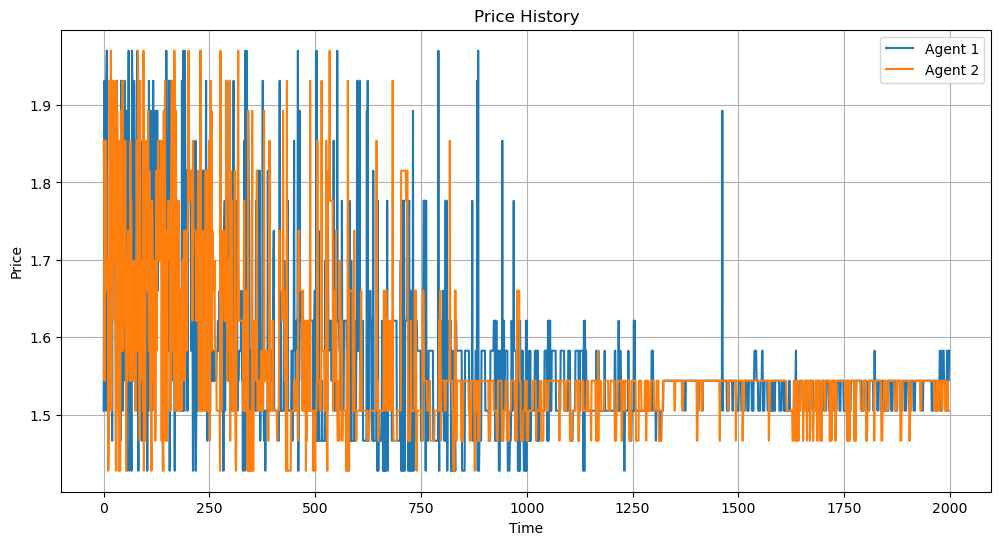

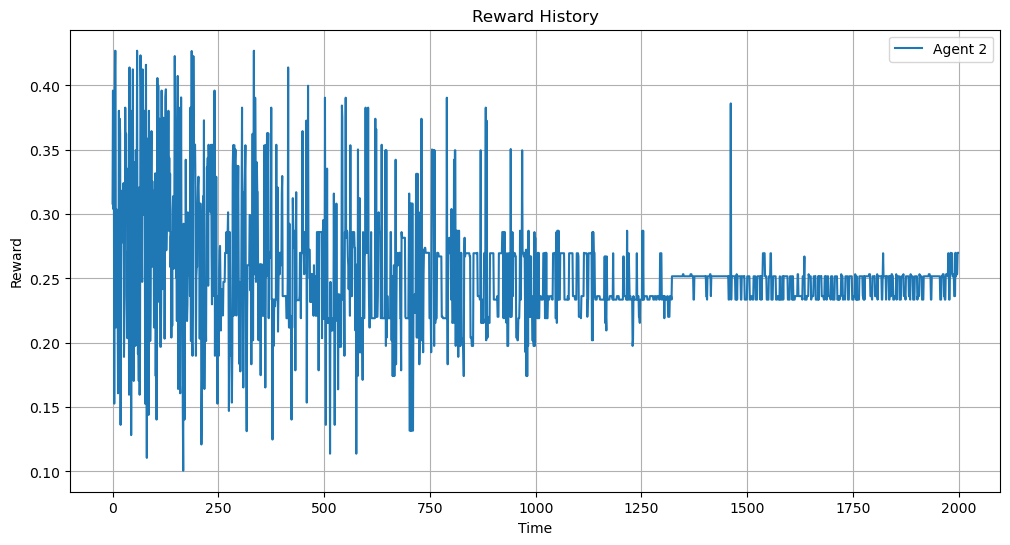

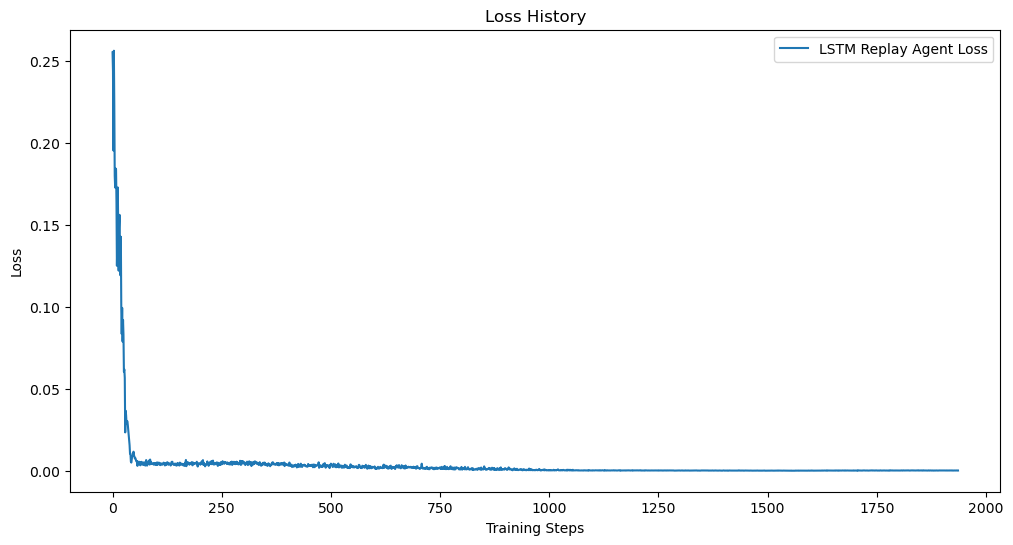

In [37]:
import pickle

import matplotlib.pyplot as plt

# Load the data from the file
file_name = "lstm_replay_agent_data.pkl"

with open(file_name, "rb") as f:
	data = pickle.load(f)

# Extract price, reward, and loss histories
price_history = data["price_history"]
reward_history = data["reward_history"]
loss_history = data["loss_history"]

# Plot price history
plt.figure(figsize=(12, 6))
for agent_idx in range(len(price_history[0])):  # Iterate over agents
	agent_prices = [prices[agent_idx] for prices in price_history]
	plt.plot(agent_prices[:], label=f"Agent {agent_idx + 1}")
plt.title("Price History")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Plot reward history
plt.figure(figsize=(12, 6))

for agent_idx in range(len(reward_history[0])):  # Iterate over agents
	agent_rewards = [rewards[agent_idx] for rewards in reward_history]

plt.plot(agent_rewards[:], label=f"Agent {agent_idx + 1}")
plt.title("Reward History")
plt.xlabel("Time")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# Plot loss history
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label="LSTM Replay Agent Loss")
plt.title("Loss History")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [265]:
def run_multiple_simulations(n_runs=10, output_file="simulation_histories.pkl"):
    all_histories = {
        "prices": {},
        "quantities": {},
        "rewards": {}
    }

    for i in range(n_runs):
        print(f"Running simulation {i + 1}/{n_runs}...")

        # Set up the environment
        env = DiscreteSynchronEnvironment(
            markup=0.1,
            n_periods=1000,
            possible_prices=[],
            n_prices=15,
            demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
            history_after=0,
            agents=[
                LSTMReplayAgent(
                    discount=0.95,
                    learning_rate=0.001,
                    decision=DecreasingEpsilonGreedy(),
                    marginal_cost=1.0,
                    quality=2.0,
                    sequence_length=10,
                    batch_size=32,
                    use_soft_update=True,
                    TAU=0.001,
                    replay_buffer_capacity=200,
                ),
                LSTMReplayAgent(
                    discount=0.95,
                    learning_rate=0.001,
                    decision=DecreasingEpsilonGreedy(),
                    marginal_cost=1.0,
                    quality=2.0,
                    sequence_length=10,
                    batch_size=32,
                    use_soft_update=True,
                    TAU=0.001,
                    replay_buffer_capacity=200,
                ),
            ],
        )

        # Run the simulation
        env.play_game()

        # Collect histories with run identifiers
        all_histories["prices"][f"run_{i + 1}"] = env.price_history
        all_histories["quantities"][f"run_{i + 1}"] = env.quantity_history
        all_histories["rewards"][f"run_{i + 1}"] = env.reward_history

    # Save all histories to a file
    save_object(all_histories, output_file)
    print(f"Simulation histories saved to {output_file}")

In [267]:
os.cpu_count()

12

In [266]:
run_multiple_simulations(n_runs=10)

Running simulation 1/10...
Period 0/100000
Period 25000/100000
Period 50000/100000
Period 75000/100000
Run 1 saved to simulation_20250424_201330.pkl
Running simulation 2/10...
Period 0/100000
Period 25000/100000
Period 50000/100000
Period 75000/100000
Run 2 saved to simulation_20250424_201330.pkl
Running simulation 3/10...
Period 0/100000


KeyboardInterrupt: 

In [220]:
import pickle
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# File path to the saved simulation data
file_path = "simulation_20250424_074713.pkl"  # Replace with your actual file name

# Assume 'data.pkl' contains multiple pickled objects
for obj in load_multiple_objects(file_path):
    print(obj)  # Process each object one at a time

ModuleNotFoundError: No module named 'numpy._core'

In [221]:
print(np.__version__)

1.21.5


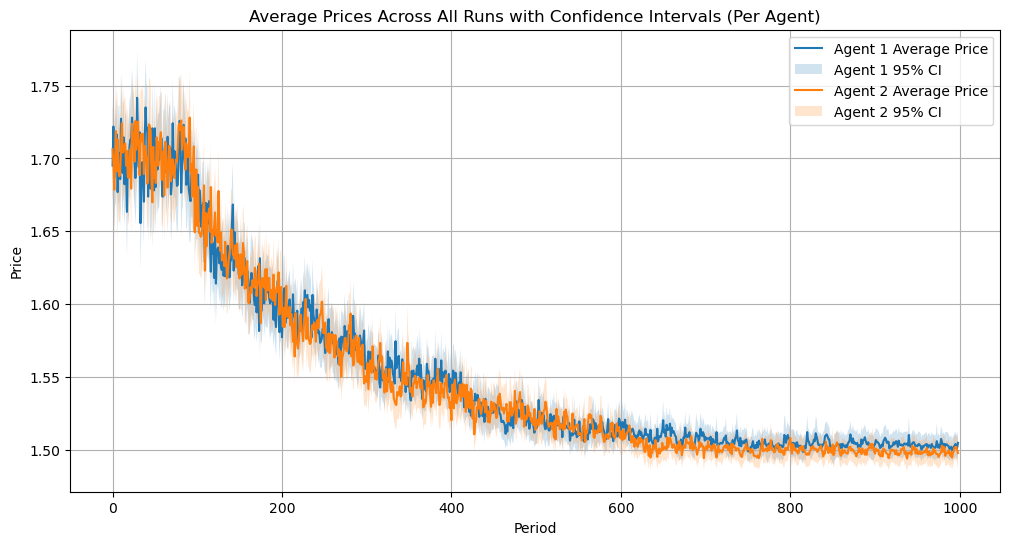

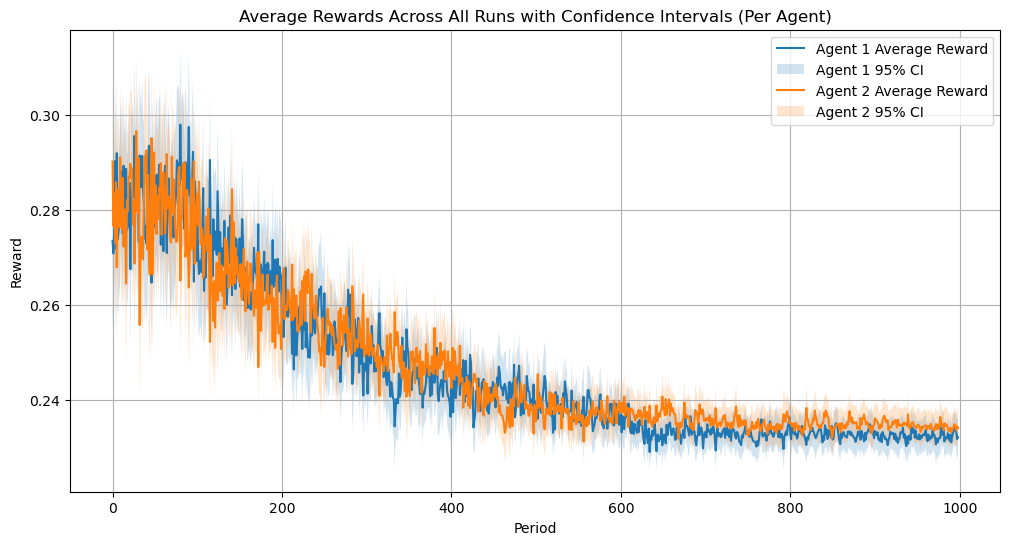

In [27]:
from price_simulator.src.utils.serializer import load_object
import numpy as np
import matplotlib.pyplot as plt

# Load the simulation histories
file_path = "simulation_histories.pkl"
histories = load_object(file_path)

# Extract price data
prices = histories["prices"]

# Convert price data to a 3D numpy array (runs x periods x agents)
all_prices = np.array(list(prices.values()))

# Ensure all_prices is 3D
if all_prices.ndim != 3:
    raise ValueError("Expected 'all_prices' to be a 3D array (runs x periods x agents).")

# Number of agents
n_agents = all_prices.shape[2]

# Plot average prices with confidence intervals for each agent
plt.figure(figsize=(12, 6))

for agent_idx in range(n_agents):
    # Extract prices for the current agent
    agent_prices = all_prices[:, :, agent_idx]  # Shape: (runs x periods)

    # Calculate average prices for each period across all runs
    average_prices = np.mean(agent_prices, axis=0)

    # Calculate the 95% confidence interval
    # CI = 1.96 * (standard deviation / sqrt(number of runs))
    std_prices = np.std(agent_prices, axis=0)
    n_runs = agent_prices.shape[0]
    confidence_interval = 1.96 * (std_prices / np.sqrt(n_runs))

    # Plot average prices with confidence interval for the current agent
    plt.plot(average_prices, label=f"Agent {agent_idx + 1} Average Price")
    plt.fill_between(
        range(len(average_prices)),
        average_prices - confidence_interval,
        average_prices + confidence_interval,
        alpha=0.2,
        label=f"Agent {agent_idx + 1} 95% CI"
    )

# Add plot details
plt.title("Average Prices Across All Runs with Confidence Intervals (Per Agent)")
plt.xlabel("Period")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Extract reward data
rewards = histories["rewards"]

# Convert reward data to a 3D numpy array (runs x periods x agents)
all_rewards = np.array(list(rewards.values()))

# Ensure all_rewards is 3D
if all_rewards.ndim != 3:
    raise ValueError("Expected 'all_rewards' to be a 3D array (runs x periods x agents).")

# Plot average rewards with confidence intervals for each agent
plt.figure(figsize=(12, 6))

for agent_idx in range(n_agents):
    # Extract rewards for the current agent
    agent_rewards = all_rewards[:, :, agent_idx]  # Shape: (runs x periods)

    # Calculate average rewards for each period across all runs
    average_rewards = np.mean(agent_rewards, axis=0)

    # Calculate the 95% confidence interval
    std_rewards = np.std(agent_rewards, axis=0)
    n_runs = agent_rewards.shape[0]
    confidence_interval = 1.96 * (std_rewards / np.sqrt(n_runs))

    # Plot average rewards with confidence interval for the current agent
    plt.plot(average_rewards, label=f"Agent {agent_idx + 1} Average Reward")
    plt.fill_between(
        range(len(average_rewards)),
        average_rewards - confidence_interval,
        average_rewards + confidence_interval,
        alpha=0.2,
        label=f"Agent {agent_idx + 1} 95% CI"
    )

# Add plot details
plt.title("Average Rewards Across All Runs with Confidence Intervals (Per Agent)")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

In [49]:
all_rewards.shape

(100, 999, 2)

### Multiprocessing

In [40]:
from datetime import datetime
import pickle
from concurrent.futures import ThreadPoolExecutor

def run_simulation(simulation_id, output_file_prefix="simulation"):
    """Run a single simulation and save the results."""
    print(f"Running simulation {simulation_id}...")

    # Set up the environment
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=100000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=0,
        agents=[
            LSTMReplayAgent(
                discount=0.95,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                sequence_length=15,
                batch_size=32,
                use_soft_update=True,
                TAU=0.001,
                replay_buffer_capacity=250,
            ),
            LSTMReplayAgent(
                discount=0.95,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                sequence_length=15,
                batch_size=32,
                use_soft_update=True,
                TAU=0.001,
                replay_buffer_capacity=250,
            ),
        ],
    )

    # Run the simulation
    env.play_game()

    # Collect data for this run
    run_data = {
        "run_id": simulation_id,
        "parameters": {
            "environment": {
                "markup": env.markup,
                "n_periods": env.n_periods,
                "n_prices": env.n_prices,
                "demand": {
                    "type": type(env.demand).__name__,
                    "outside_quality": env.demand.outside_quality,
                    "price_sensitivity": env.demand.price_sensitivity,
                },
            },
            "agents": [
                {
                    "type": type(agent).__name__,
                    "discount": agent.discount,
                    "learning_rate": agent.learning_rate,
                    "sequence_length": agent.sequence_length,
                    "batch_size": agent.batch_size,
                    "use_soft_update": agent.use_soft_update,
                    "TAU": agent.TAU,
                    "marginal_cost": agent.marginal_cost,
                    "quality": agent.quality,
                }
                for agent in env.agents
            ],
        },
        "histories": {
            "prices": env.price_history,
            "quantities": env.quantity_history,
            "rewards": env.reward_history,
        },
    }

    # Save the run data to a file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"{output_file_prefix}_{timestamp}_run_{simulation_id}.pkl"
    with open(output_file, "wb") as f:
        pickle.dump(run_data, f)

    print(f"Simulation {simulation_id} saved to {output_file}")


import torch.multiprocessing as mp

cpu_count = os.cpu_count()
def run_multiple_simulations_parallel(n_runs=10, max_workers=cpu_count, output_file_prefix="simulation_results"):
    """Run multiple simulations in parallel and save all results to a single file with a timestamp."""
    all_results = []  # List to store results of all simulations

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(run_simulation, i + 1) for i in range(n_runs)]
        for future in futures:
            all_results.append(future.result())  # Collect results from each simulation

    # Save all results to a single file with a timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"{output_file_prefix}_{timestamp}.pkl"
    with open(output_file, "wb") as f:
        pickle.dump(all_results, f)

    print(f"All simulations completed. Results saved to {output_file}")
# Run 10 simulations in parallel using 4 CPU cores
run_multiple_simulations_parallel(n_runs=10, max_workers=cpu_count)

Running simulation 1...
Running simulation 2...
Running simulation 3...
Running simulation 4...
Running simulation 5...
Running simulation 6...
Running simulation 7...Running simulation 8...

Running simulation 9...
Running simulation 10...
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 0/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 25000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 50000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000
Period 75000/100000

In [43]:
import pickle
import glob

# Define the pattern to match the files
file_pattern = "simulation_20250425_18*_run_*.pkl"

# Get all matching files
files_to_merge = sorted(glob.glob(file_pattern))

# List to store all data
merged_data = []

# Load data from each file and append it to the merged_data list
for file in files_to_merge:
	with open(file, "rb") as f:
		data = pickle.load(f)
		merged_data.append(data)

# Save the merged data into a single file
output_file = "merged_simulation_20250425_4.pkl"
with open(output_file, "wb") as f:
	pickle.dump(merged_data, f)

print(f"Merged {len(files_to_merge)} files into {output_file}")

Merged 10 files into merged_simulation_20250425_3.pkl


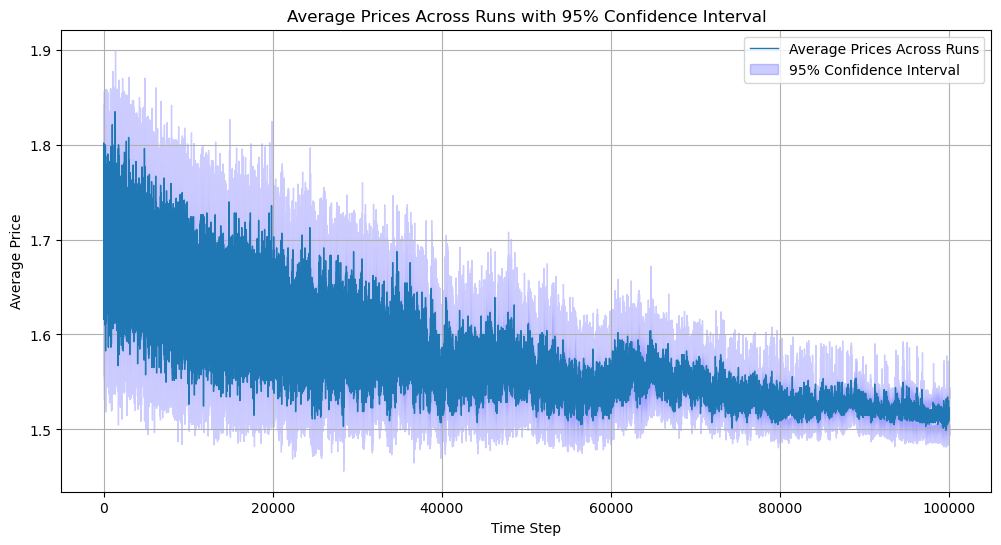

In [44]:
# Calculate the average prices across runs
average_prices_across_runs = np.mean(
	[np.mean(run['histories']['prices'], axis=1) for run in merged_data], axis=0
)

# Calculate the standard deviation across runs
std_dev = np.std(
	[np.mean(run['histories']['prices'], axis=1) for run in merged_data], axis=0
)

# Calculate the 95% confidence interval
n_runs = len(merged_data)
confidence_interval = 1.96 * std_dev / np.sqrt(n_runs)

# Plot the average prices with the 95% confidence interval
plt.figure(figsize=(12, 6))
plt.plot(average_prices_across_runs, label="Average Prices Across Runs", alpha=1, linewidth=1)
plt.fill_between(
	range(len(average_prices_across_runs)),
	average_prices_across_runs - confidence_interval,
	average_prices_across_runs + confidence_interval,
	color='b',
	alpha=0.2,
	label="95% Confidence Interval"
)
plt.title("Average Prices Across Runs with 95% Confidence Interval")
plt.xlabel("Time Step")
plt.ylabel("Average Price")
plt.legend()
plt.grid()
plt.show()


## DQN implementation (adjusted)

### DQN pyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchrl.data import TensorDictReplayBuffer, LazyTensorStorage
from tensordict import TensorDict
from typing import List, Tuple
import attr
import numpy as np

class DQNModel(nn.Module):
    """Simple feedforward neural network for DQN."""
    def __init__(self, input_size, hidden_size, output_size):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


@attr.s
class DQNAgent(AgentStrategy):
    """DQN Agent with PyTorch and TensorDictReplayBuffer."""

    # Neural Network
    qnetwork: DQNModel = attr.ib(default=None)
    target_qnetwork: DQNModel = attr.ib(default=None, init=False)
    hidden_nodes: int = attr.ib(default=32)

    # Replay Buffer
    replay_buffer_capacity: int = attr.ib(default=1000)
    batch_size: int = attr.ib(default=32)

    # General
    decision: ExplorationStrategy = attr.ib(factory=EpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.01)
    update_target_after: int = attr.ib(default=100)
    update_counter: int = attr.ib(default=0, init=False)
    loss_history: List[float] = attr.ib(factory=list, init=False)

    # Debugging
    debug: bool = attr.ib(default=False)

    def __attrs_post_init__(self):
        # Initialize replay buffer
        self.replay_buffer = TensorDictReplayBuffer(
            storage=LazyTensorStorage(self.replay_buffer_capacity),
            batch_size=self.batch_size,
        )

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Select an action using epsilon-greedy policy."""
        if self.debug:
            print(f"\n")

        # Initialize Q-network if necessary
        if not self.qnetwork:
            self.qnetwork = self.initialize_network(len(state), len(action_space))
            if self.debug:
                print(f"Initialized Q-network with input size {len(state)} and output size {len(action_space)}")

        # Exploration or exploitation
        if self.decision.explore(n_period, t):
            chosen_action = random.choice(action_space)
            if self.debug:
                print(f"Exploration chosen. Random action: {chosen_action}")
            return chosen_action
        else:
            state = self.scale(state, action_space)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            action_values = self.qnetwork(state_tensor).detach().numpy()
            if self.debug:
                print(f"Action values: {action_values}")
            
            # Handle ties by checking if multiple actions have the same maximum value
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])

            chosen_action = action_space[optimal_action_index]
            if self.debug:
                print(f"Chosen action: {chosen_action}")
            return chosen_action

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Train the Q-network using transitions from the replay buffer."""

        # Add transition to replay buffer
        action = torch.tensor([action_space.index(action)], dtype=torch.int64)
        state = self.scale(state, action_space)
        next_state = self.scale(next_state, action_space)

        transition = TensorDict(
            {
            "state": torch.tensor(state, dtype=torch.float32),
            "action": torch.tensor([action], dtype=torch.long),
            "reward": torch.tensor([reward], dtype=torch.float32),
            "next_state": torch.tensor(next_state, dtype=torch.float32),
            },
            batch_size=[],
        )

        self.replay_buffer.add(transition)

        # Train only if enough samples are available
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of transitions
        batch = self.replay_buffer.sample()
        states = batch["state"]
        action_indices = batch["action"].squeeze(1)
        rewards = batch["reward"].squeeze(1)
        next_states = batch["next_state"]
        
        # Compute max predicted Q-values for next state using the target network
        next_q_values = self.target_qnetwork(next_states).max(1)[0].detach()
        
        # Compute Q targets for current states
        targets = rewards + self.discount * next_q_values

        # Get current Q values from local model and update them
        local_estimates = self.qnetwork(states)
        local_estimates = local_estimates.gather(1, action_indices.unsqueeze(1)).squeeze(1)

        # Compute loss and update the network
        optimizer = optim.Adam(self.qnetwork.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(local_estimates, targets)
        loss.backward()
        optimizer.step()

        # Update the target network periodically
        self.update_counter += 1
        if self.update_counter % self.update_target_after == 0:
            self.target_qnetwork.load_state_dict(self.qnetwork.state_dict())
            if self.debug:
                print("Target network updated.")

        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, input_size: int, output_size: int) -> DQNModel:
        """Initialize the Q-network and target network."""
        qnetwork = DQNModel(input_size=input_size, hidden_size=self.hidden_nodes, output_size=output_size)
        self.target_qnetwork = DQNModel(input_size=input_size, hidden_size=self.hidden_nodes, output_size=output_size)
        self.target_qnetwork.load_state_dict(qnetwork.state_dict())  # Synchronize weights initially
        self.target_qnetwork.eval()  # Target network is not trained directly
        return qnetwork
    
    @staticmethod
    def scale(inputs: Tuple, action_space: List) -> np.array:
        """Scale float input to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.multiply(np.divide(np.array(inputs) - min_action, max_action - min_action), 1)


Period 0/10000 (0.00%)
Period 100/10000 (1.00%)
Period 200/10000 (2.00%)
Period 300/10000 (3.00%)
Period 400/10000 (4.00%)
Period 500/10000 (5.00%)
Period 600/10000 (6.00%)
Period 700/10000 (7.00%)
Period 800/10000 (8.00%)
Period 900/10000 (9.00%)
Period 1000/10000 (10.00%)
Period 1100/10000 (11.00%)
Period 1200/10000 (12.00%)
Period 1300/10000 (13.00%)
Period 1400/10000 (14.00%)
Period 1500/10000 (15.00%)
Period 1600/10000 (16.00%)
Period 1700/10000 (17.00%)
Period 1800/10000 (18.00%)
Period 1900/10000 (19.00%)
Period 2000/10000 (20.00%)
Period 2100/10000 (21.00%)
Period 2200/10000 (22.00%)
Period 2300/10000 (23.00%)
Period 2400/10000 (24.00%)
Period 2500/10000 (25.00%)
Period 2600/10000 (26.00%)
Period 2700/10000 (27.00%)
Period 2800/10000 (28.00%)
Period 2900/10000 (29.00%)
Period 3000/10000 (30.00%)
Period 3100/10000 (31.00%)
Period 3200/10000 (32.00%)
Period 3300/10000 (33.00%)
Period 3400/10000 (34.00%)
Period 3500/10000 (35.00%)
Period 3600/10000 (36.00%)
Period 3700/10000 (37.0

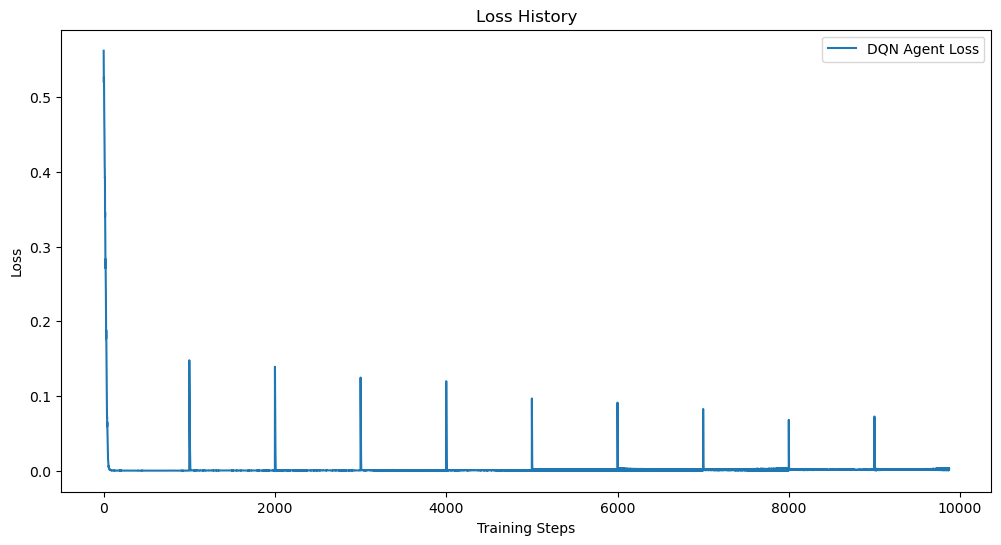

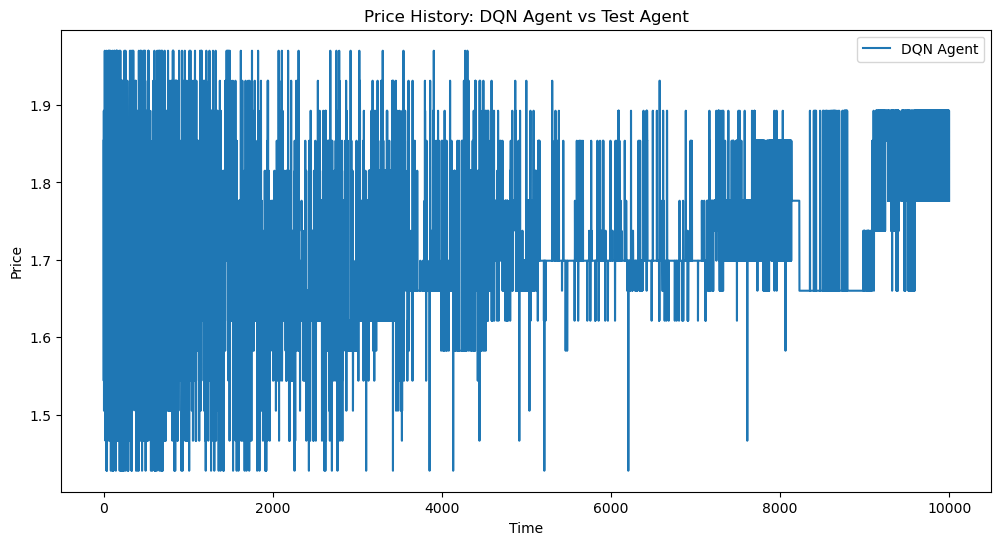

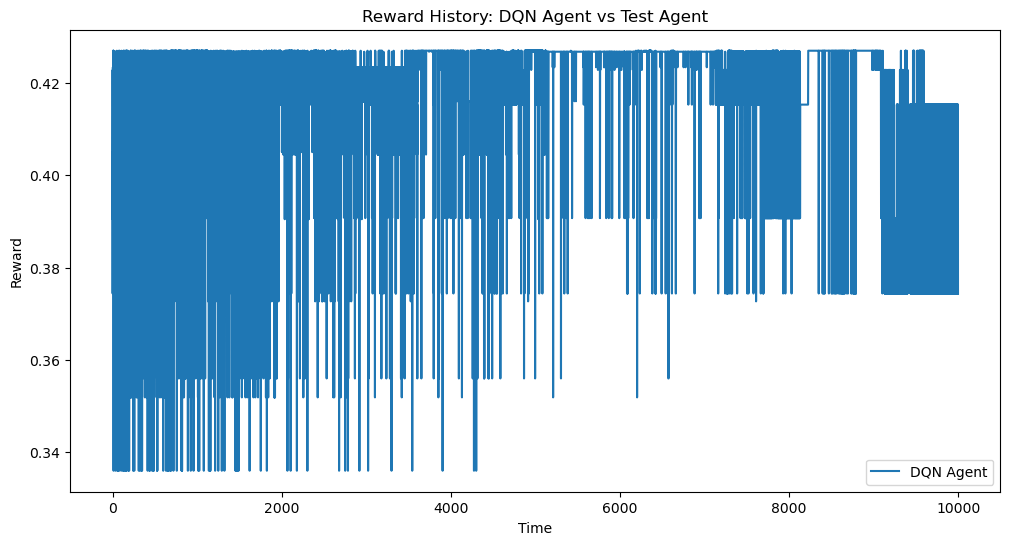

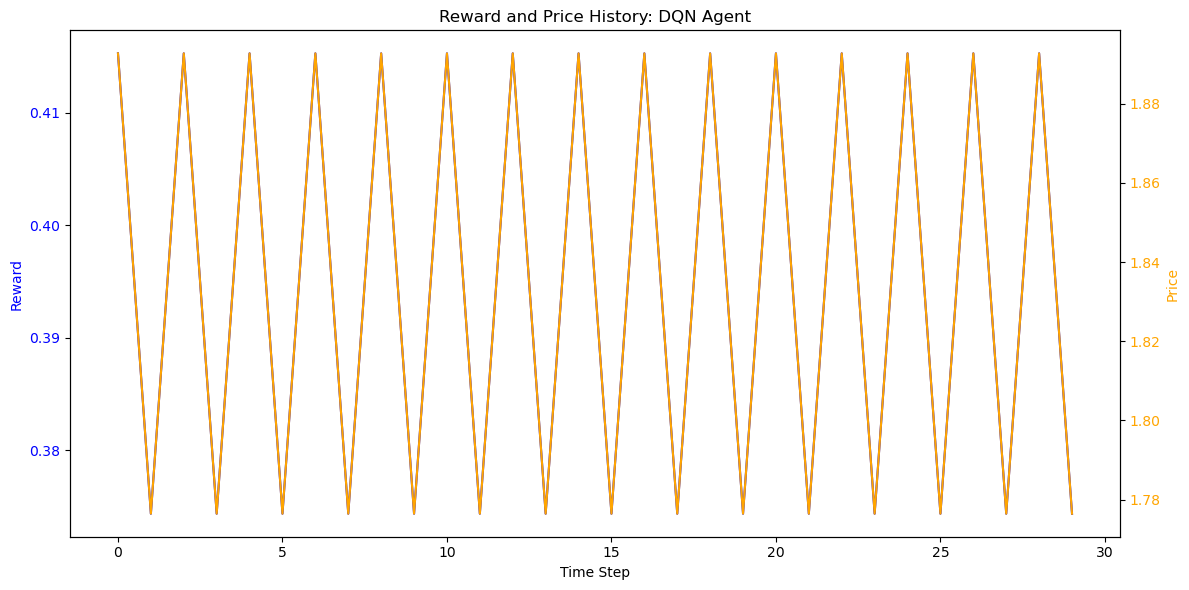

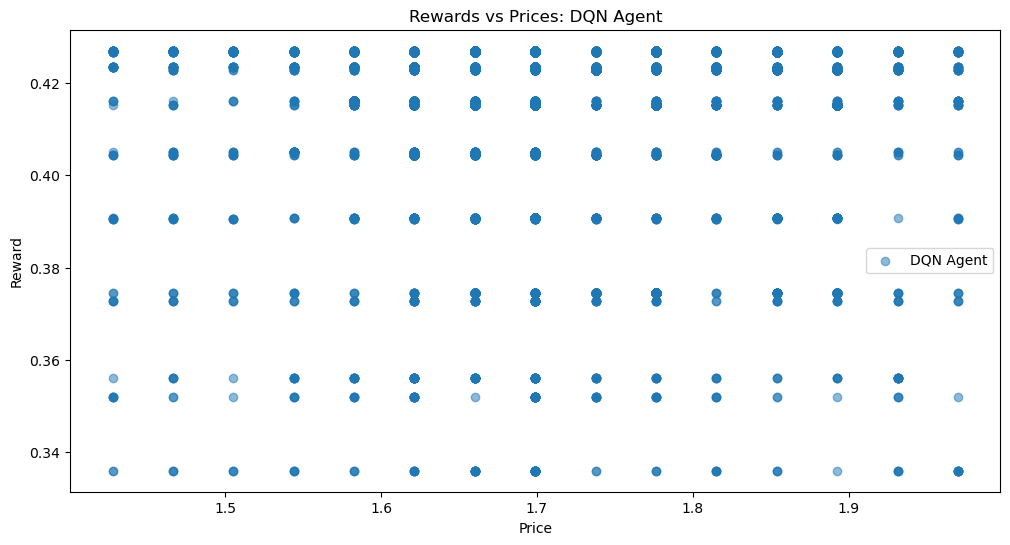

In [ ]:
import matplotlib.pyplot as plt

def test_dqn_agent():
    # Create an environment with one DQNAgent and one AlwaysDefectAgent
    env = DiscreteSynchronEnvironment(
        markup=0.1,
        n_periods=10000,
        possible_prices=[],
        n_prices=15,
        demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
        history_after=0,
        agents=[
            DQNAgent(
                discount=0.95,
                learning_rate=0.001,
                decision=DecreasingEpsilonGreedy(),
                marginal_cost=1.0,
                quality=2.0,
                batch_size=128,
                update_target_after=1000,
                hidden_nodes=32,
                debug=False,
            ),
            AlwaysMaxAgent(
                marginal_cost=1.0,
                quality=2.0,
            ),
        ],
        debug=False,
    )

    # Simulate the environment
    env.play_game()

    # Analyze and visualize results
    price_history_dqn = [price[0] for price in env.price_history]
    price_history_defect = [price[1] for price in env.price_history]

    # Plot loss history
    plt.figure(figsize=(12, 6))
    plt.plot(env.agents[0].loss_history, label="DQN Agent Loss")
    plt.title("Loss History")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot price history
    plt.figure(figsize=(12, 6))
    plt.plot(price_history_dqn, label="DQN Agent")
    #plt.plot(price_history_defect, label="Test Agent")
    plt.title("Price History: DQN Agent vs Test Agent")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot reward history
    reward_history_dqn = [reward[0] for reward in env.reward_history]
    reward_history_defect = [reward[1] for reward in env.reward_history]
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history_dqn, label="DQN Agent")
    #plt.plot(reward_history_defect, label="Test Agent")
    plt.title("Reward History: DQN Agent vs Test Agent")
    plt.xlabel("Time")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

    # Overlay rewards and prices for comparison
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot rewards on the left y-axis
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Reward", color="blue")
    ax1.plot(reward_history_dqn[-30:], label="Reward", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Plot prices on the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Price", color="orange")
    ax2.plot(price_history_dqn[-30:], label="Price", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    plt.title("Reward and Price History: DQN Agent")
    fig.tight_layout()
    plt.show()
    # Plot rewards against prices
    plt.figure(figsize=(12, 6))
    plt.scatter(price_history_dqn, reward_history_dqn, alpha=0.5, label="DQN Agent")
    plt.title("Rewards vs Prices: DQN Agent")
    plt.xlabel("Price")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()


test_dqn_agent()

### DQN tensorFlow
original by Hettich

In [ ]:
import random
from typing import List, Tuple

import attr

import keras
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from price_simulator.src.algorithm.agents.buffer import ReplayBuffer
from price_simulator.src.algorithm.agents.simple import AgentStrategy
from price_simulator.src.algorithm.policies import EpsilonGreedy, ExplorationStrategy


@attr.s
class DQN(AgentStrategy):
    """Deep-Q-Netowrks Agent with discounted reward formulation"""

    # Q-Network
    qnetwork_target: keras.models = attr.ib(default=None)
    qnetwork_local: keras.models = attr.ib(default=None)
    update_target_after: int = attr.ib(default=100)
    replay_memory: ReplayBuffer = attr.ib(factory=ReplayBuffer)
    batch_size: int = attr.ib(default=32)
    update_counter: int = attr.ib(default=0)
    hidden_nodes: int = attr.ib(default=32)

    # General
    decision: ExplorationStrategy = attr.ib(factory=EpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.1)

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        """For learning_rate = 0, the algorithm does not learn at all.
        For learning_rate = 1, it immediately forgets what it has learned in the past.
        """
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def who_am_i(self) -> str:
        # TODO better who am i
        return type(self).__name__ + " (gamma: {}, alpha: {}, policy: {}, quality: {}, mc: {})".format(
            self.discount, self.learning_rate, self.decision.who_am_i(), self.quality, self.marginal_cost
        )

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""

        # init q networks if necessary
        if not self.qnetwork_target or not self.qnetwork_local:
            self.qnetwork_target = self.initialize_network(len(state), len(action_space))
            self.qnetwork_local = self.initialize_network(len(state), len(action_space))
            self.qnetwork_target.set_weights(self.qnetwork_local.get_weights())

        # play action
        if self.decision.explore(n_period, t):
            return random.choice(action_space)
        else:
            action_values = self.qnetwork_local.predict(np.expand_dims(self.scale(state, action_space), axis=0))
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])
            return action_space[optimal_action_index]

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List,
        previous_state: Tuple,
        state: Tuple,
        next_state: Tuple,
    ):
        # store experience in buffer (action is converted to index)
        action = np.where(action_space == action)[0]
        state = self.scale(state, action_space)
        next_state = self.scale(next_state, action_space)
        self.replay_memory.add(state, action, reward, next_state)

        if len(self.replay_memory) > self.batch_size:

            # get training sample
            states, actions, rewards, next_states = self.replay_memory.sample(self.batch_size)

            # Get max predicted Q values (for next states) from target model
            next_optimal_q = np.amax(self.qnetwork_target.predict(next_states), axis=1, keepdims=True)

            # Compute Q targets for current states
            targets = rewards + self.discount * next_optimal_q

            # Get current Q values from local model and update them
            # with better estimates (target) for the played actions
            local_estimates = self.qnetwork_local.predict(states)
            local_estimates[np.arange(len(actions)), actions.flatten()] = targets.flatten()

            # perform gradient descent step on local network
            self.qnetwork_local.fit(states, local_estimates, epochs=1, verbose=0, batch_size=self.batch_size)

            # update target_qnetwork after some periods
            self.update_counter += 1
            if self.update_counter == self.update_target_after:
                self.qnetwork_target.set_weights(self.qnetwork_local.get_weights())
                self.update_counter = 0
                print("I updated my target model")

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neuronal network with one output node per possible action"""
        model = Sequential()
        model.add(Dense(int(self.hidden_nodes), input_dim=n_agents, activation="relu"))
        model.add(Dense(int(self.hidden_nodes), activation="relu"))
        model.add(Dense(n_actions, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model

    @staticmethod
    def scale(inputs: Tuple, action_space: List) -> np.array:
        """Scale float input to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.multiply(np.divide(np.array(inputs) - min_action, max_action - min_action), 1)



In [ ]:
def test_dqn_vs_always_max():
	# Create an environment with one DQN agent and one AlwaysMaxAgent
	env = DiscreteSynchronEnvironment(
		markup=0.1,
		n_periods=100,
		possible_prices=[],
		n_prices=15,
		demand=LogitDemand(outside_quality=0.0, price_sensitivity=0.25),
		history_after=0,
		agents=[
			DQN(
				discount=0.95,
				learning_rate=0.001,
				decision=DecreasingEpsilonGreedy(),
				marginal_cost=1.0,
				quality=2.0,
			),
			AlwaysMaxAgent(
				marginal_cost=1.0,
				quality=2.0,
			),
		],
		debug=False,
	)

	# Simulate the environment
	env.play_game()

	# Analyze and visualize results
	price_history_dqn = [price[0] for price in env.price_history]
	price_history_max = [price[1] for price in env.price_history]

	# Plot price history
	plt.figure(figsize=(12, 6))
	plt.plot(price_history_dqn, label="DQN Agent")
	plt.plot(price_history_max, label="Always Max Agent")
	plt.title("Price History: DQN Agent vs Always Max Agent")
	plt.xlabel("Time")
	plt.ylabel("Price")
	plt.legend()
	plt.show()

	# Plot reward history
	reward_history_dqn = [reward[0] for reward in env.reward_history]
	reward_history_max = [reward[1] for reward in env.reward_history]
	plt.figure(figsize=(12, 6))
	plt.plot(reward_history_dqn, label="DQN Agent")
	plt.plot(reward_history_max, label="Always Max Agent")
	plt.title("Reward History: DQN Agent vs Always Max Agent")
	plt.xlabel("Time")
	plt.ylabel("Reward")
	plt.legend()
	plt.show()

	# Plot rewards against prices for the DQN agent
	plt.figure(figsize=(12, 6))
	plt.scatter(price_history_dqn, reward_history_dqn, alpha=0.5, label="DQN Agent")
	plt.title("Rewards vs Prices: DQN Agent")
	plt.xlabel("Price")
	plt.ylabel("Reward")
	plt.legend()
	plt.show()

test_dqn_vs_always_max()


Period 0/100 (0.00%)
Period 1/100 (1.00%)
Period 2/100 (2.00%)
Period 3/100 (3.00%)
Period 4/100 (4.00%)
Period 5/100 (5.00%)
Period 6/100 (6.00%)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


d:\Programme HDD\miniconda\envs\price_simulator_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 80ms/step
Period 7/100 (7.00%)
Period 8/100 (8.00%)
1/1 [==============================] - 0s 19ms/step
Period 9/100 (9.00%)
1/1 [==============================] - 0s 18ms/step
Period 10/100 (10.00%)
1/1 [==============================] - 0s 18ms/step
Period 11/100 (11.00%)
1/1 [==============================] - 0s 18ms/step
Period 12/100 (12.00%)
Period 13/100 (13.00%)
1/1 [==============================] - 0s 20ms/step
Period 14/100 (14.00%)
1/1 [==============================] - 0s 18ms/step
Period 15/100 (15.00%)
1/1 [==============================] - 0s 18ms/step
Period 16/100 (16.00%)
1/1 [==============================] - 0s 18ms/step
Period 17/100 (17.00%)
1/1 [==============================] - 0s 18ms/step
Period 18/100 (18.00%)
1/1 [==============================] - 0s 21ms/step
Period 19/100 (19.00%)
1/1 [==============================] - 0s 27ms/step
Period 20/100 (20.00%)
1/1 [==============================] - 0s 20ms/step
Period 2

KeyboardInterrupt: 

In [ ]:

@attr.s
class LSTMReplayAgent(AgentStrategy):
    """LSTM Agent with Replay Buffer for Reinforcement Learning"""

    # LSTM Network
    lstm: LSTMModel = attr.ib(default=None)
    hidden_nodes: int = attr.ib(default=32)
    sequence_length: int = attr.ib(default=5)  # Number of past states to use
    state_history: List[Tuple[float, ...]] = attr.ib(factory=list)

    # Target Network
    target_lstm: LSTMModel = attr.ib(default=None, init=False)  # Target network
    update_counter: int = attr.ib(default=0, init=False)  # Counter for target updates
    update_target_after: int = attr.ib(default=250)
    TAU: float = attr.ib(default=0.01)  # Soft update parameter

    # Replay Buffer
    replay_buffer_capacity: int = attr.ib(default=1000)
    batch_size: int = attr.ib(default=32)

    # General
    decision: ExplorationStrategy = attr.ib(factory=DecreasingEpsilonGreedy)
    discount: float = attr.ib(default=0.95)
    learning_rate: float = attr.ib(default=0.001)
    loss_history: List[float] = attr.ib(factory=list, init=False)

    # Debugging
    debug: bool = attr.ib(default=False)
    

    def __attrs_post_init__(self):
        # Initialize replay buffer
        self.replay_buffer = TensorDictReplayBuffer(
            storage=LazyTensorStorage(self.replay_buffer_capacity),
            batch_size=self.batch_size,
        )

    @discount.validator
    def check_discount(self, attribute, value):
        if not 0 <= value <= 1:
            raise ValueError("Discount factor must lie in [0,1]")

    @learning_rate.validator
    def check_learning_rate(self, attribute, value):
        if not 0 <= value < 1:
            raise ValueError("Learning rate must lie in [0,1)")

    def update_state_history(self, state: Tuple[float]):
        """Update the history of states with the new state."""
        self.state_history.append(state)
        if len(self.state_history) > self.sequence_length:
            self.state_history.pop(0)
        # Add zero padding if the state history is shorter than the sequence length
        while len(self.state_history) < self.sequence_length:
            self.state_history.insert(0, tuple(0.0 for _ in state))

    def play_price(self, state: Tuple[float], action_space: List[float], n_period: int, t: int) -> float:
        """Returns an action by either following greedy policy or experimentation."""
        # Update state history
        self.update_state_history(self.scale_sequence(state, action_space))

        # Initialize LSTM network if necessary
        if not self.lstm:
            self.lstm = self.initialize_network(len(state), len(action_space))

        # Play action
        if self.decision.explore(n_period, t):
            chosen_action = random.choice(action_space)
            return chosen_action
        else:
            # Use state history as input to the LSTM network
            states_input = torch.tensor(self.state_history).float().unsqueeze(0)
            action_values = self.lstm(states_input).detach().numpy()
            if sum(np.isclose(action_values[0], action_values[0].max())) > 1:
                optimal_action_index = np.random.choice(
                    np.flatnonzero(np.isclose(action_values[0], action_values[0].max()))
                )
            else:
                optimal_action_index = np.argmax(action_values[0])
            chosen_action = action_space[optimal_action_index]
            return chosen_action

    def learn(
        self,
        previous_reward: float,
        reward: float,
        previous_action: float,
        action: float,
        action_space: List[float],
        previous_state: Tuple[float],
        state: Tuple[float],
        next_state: Tuple[float],
    ):
        """Update the LSTM network based on the observed rewards and actions."""

        # Add transition to replay buffer
        scaled_next_state = self.scale_sequence([next_state], action_space)[0]
        next_state_history = self.state_history[-(self.sequence_length - 1):] + [scaled_next_state]
        action = torch.tensor([action_space.index(action)], dtype=torch.int64)
        
        transition = TensorDict(
            {
            "state": torch.tensor(self.state_history[-self.sequence_length:], dtype=torch.float32),
            "action": action,
            "reward": torch.tensor([reward], dtype=torch.float32),
            "next_state": torch.tensor(next_state_history, dtype=torch.float32),
            },
            batch_size=[],
        )

        self.replay_buffer.add(transition)

        # Train only if enough samples are available
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of transitions
        batch = self.replay_buffer.sample()
        states = batch["state"]
        actions = batch["action"].squeeze(1)
        rewards = batch["reward"].squeeze(1)
        next_states = batch["next_state"]

        # Compute the target Q-values using the target network
        next_q_values = self.target_lstm(next_states).max(1)[0].detach()
        targets = rewards + self.discount * next_q_values
        
        # Get the local estimates from the LSTM network
        local_estimates = self.lstm(states)
        local_estimates = local_estimates.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute loss and update the network
        optimizer = optim.Adam(self.lstm.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss = nn.MSELoss()(local_estimates, targets)
        loss.backward()
        optimizer.step()

        # Update the target network periodically
        #self.update_counter += 1
        #if self.update_counter % self.update_target_after == 0:
        #    self.target_lstm.load_state_dict(self.lstm.state_dict())
        #    if self.debug:
        #        print("Target network updated.")

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_lstm.state_dict()
        policy_net_state_dict = self.lstm.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
        self.target_lstm.load_state_dict(target_net_state_dict)
        

        # Store the loss value
        self.loss_history.append(loss.item())

    def initialize_network(self, n_agents: int, n_actions: int):
        """Create a neural network with one output node per possible action."""
        lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm = LSTMModel(input_size=n_agents, hidden_size=self.hidden_nodes, output_size=n_actions)
        self.target_lstm.load_state_dict(lstm.state_dict())  # Synchronize weights initially
        self.target_lstm.eval()  # Target network is not trained directly
        return lstm
    
    def scale_sequence(self, sequences: List[Tuple], action_space: List) -> np.array:
        """Scale float input sequences to range from 0 to 1."""
        max_action = max(action_space)
        min_action = min(action_space)
        return np.array([
            np.multiply(np.divide(np.array(seq) - min_action, max_action - min_action), 1) for seq in sequences
        ])